In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import pynucastro as pyna
import itertools
import seaborn as sns

In [66]:
import pynucastro as pyna
from pynucastro.rates import ReacLibRate, TabularRate

# --- 1. aprox21 nuclist (+ intermediates for αp–pγ approximation) ---

aprox21_nuclei = [
    "n", "p",
    "he3", "he4",
    "n14",
    "c12", "o16",
    "ne20", "mg24", "si28", "s32", "ar36", "ca40", "ti44",
    "cr48", "fe52", "fe54", "fe56", "ni56",
    "cr56",
]

# --- 5. Build the NSE network from these rates ---
nse = pyna.NSENetwork(    
    inert_nuclei=aprox21_nuclei,  # add any “aprox-only” species you want
)

print(sorted(str(n) for n in nse.unique_nuclei))

# Example NSE query
rho = 1e8    # g/cc
T   = 7e9    # K
Ye  = 0.45

comp = nse.get_comp_nse(rho, T, Ye,
                        init_guess=(-3.5, -14.0),
                        use_coulomb_corr=True)

for nuc, X in comp.X.items():
    if X > 1e-6:
        print(nuc, X)

['Ar36', 'C12', 'Ca40', 'Cr48', 'Cr56', 'Fe52', 'Fe54', 'Fe56', 'He3', 'He4', 'Mg24', 'N14', 'Ne20', 'Ni56', 'O16', 'S32', 'Si28', 'Ti44', 'n', 'p']
n 0.00530853371098828
p 0.00021754329974901692
He4 0.0951750168917799
Si28 2.066152755445624e-06
Fe54 0.00024360375531829305
Fe56 0.46950322357717716
Cr56 0.42954829903931274


In [67]:
ds = yt.load('/mnt/research/SNAPhU/STIR/run_sukhbold/run_14may19_a1.25/run_20.0/output/stir2_14may19_s20.0_alpha1.25_hdf5_chk_0216')

yt : [WARNING  ] 2025-11-21 07:56:04,920 Extending phi dimension to 2PI + left edge.
yt : [WARNING  ] 2025-11-21 07:56:04,920 Extending theta dimension to PI + left edge.
yt : [INFO     ] 2025-11-21 07:56:04,966 Parameters: current_time              = 2.115567677404143
yt : [INFO     ] 2025-11-21 07:56:04,966 Parameters: domain_dimensions         = [240   1   1]
yt : [INFO     ] 2025-11-21 07:56:04,967 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-11-21 07:56:04,967 Parameters: domain_right_edge         = [1.50000000e+09 3.14159265e+00 6.28318531e+00]
yt : [INFO     ] 2025-11-21 07:56:04,968 Parameters: cosmological_simulation   = 0


In [85]:
ad = ds.all_data()
radius = np.array(ad['r'])
dens = np.array(ad['dens'])
temp = np.array(ad['temp'])  # Assuming 'entr' field exists in the 1D data
ye = np.array(ad['ye  '])

# Enclosed mass (approximate) as a function of radius
dr = np.gradient(radius)
mass = np.cumsum(4.0 * np.pi * radius**2 * dens * dr) / 2e33
mass[0] = 4./3. * np.pi * radius[0]**3 * dens[0]
for i in range(1, np.size(radius)):
    mass[i] = 4./3. * np.pi * (radius[i]**3 - radius[i-1]**3) * dens[i] + mass[i-1]

mass /= 2.e33

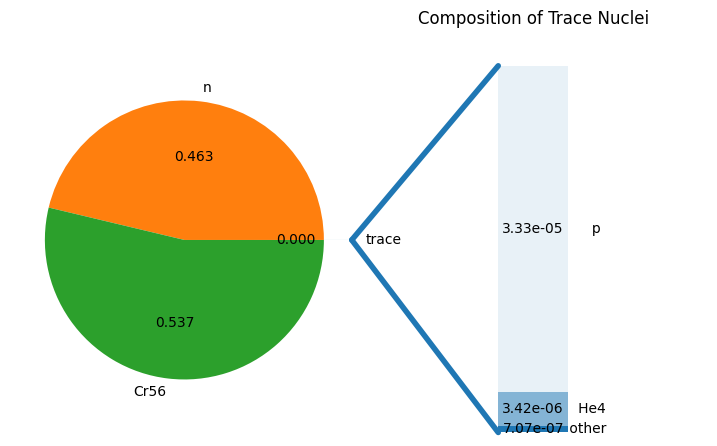

In [81]:
comp, sol = nse.get_comp_nse(dens[0], temp[0], ye[0], use_coulomb_corr=True, return_sol=True)
fig = comp.plot()

In [82]:
lib.get_nuclei()

{n,
 p,
 He3,
 He4,
 C12,
 O16,
 Ne20,
 Mg24,
 Al27,
 Si28,
 P31,
 S32,
 Cl35,
 Ar36,
 K39,
 Ca40,
 Sc43,
 Ti44,
 V47,
 Cr48,
 Mn51,
 Fe52,
 Fe54,
 Co55,
 Ni56}

In [87]:
# Radial composition: NSE for T >= 4.5e9 K, flashing otherwise
nuc_names = nse.get_nuclei()
n_zones = len(dens)
X_all = np.zeros((n_zones, len(nuc_names)))
guess = [-6.0, -11.5]
flashing_net = {
    'p':(1,1),'n':(1,0),'he3':(3,2),'he4':(4,2),'c12':(12,6),'n14':(14,7),'o16':(16,8),'ne20':(20,10),
    'mg24':(24,12),'si28':(28,14),'s32':(32,16),'ar36':(36,18),'ca40':(40,20),'ti44':(44,22),'cr48':(48,24),'cr56':(56,24),
    'fe52':(52,26),'fe54':(54,26),'fe56':(56,26),'ni56':(56,28)
}
prev_X_dict = {name:0.0 for name in nuc_names}; prev_X_dict['c12'] = 1.0
for i, (rho, T, Ye) in enumerate(zip(dens, temp, ye)):
    try:
        comp_i, sol = nse.get_comp_nse(rho, T, Ye, init_guess=guess, use_coulomb_corr=True, return_sol=True)
        guess = sol
    except Exception:
        comp_i, sol = nse.get_comp_nse(rho, T, Ye, use_coulomb_corr=True, return_sol=True)
        guess = sol
    for j, n in enumerate(nuc_names):
        X_all[i, j] = comp_i.X[n]
    prev_X_dict = {n: comp_i.X[n] for n in nuc_names}
nse_radius = radius
nse_X = X_all
nse_nuc_names = nuc_names

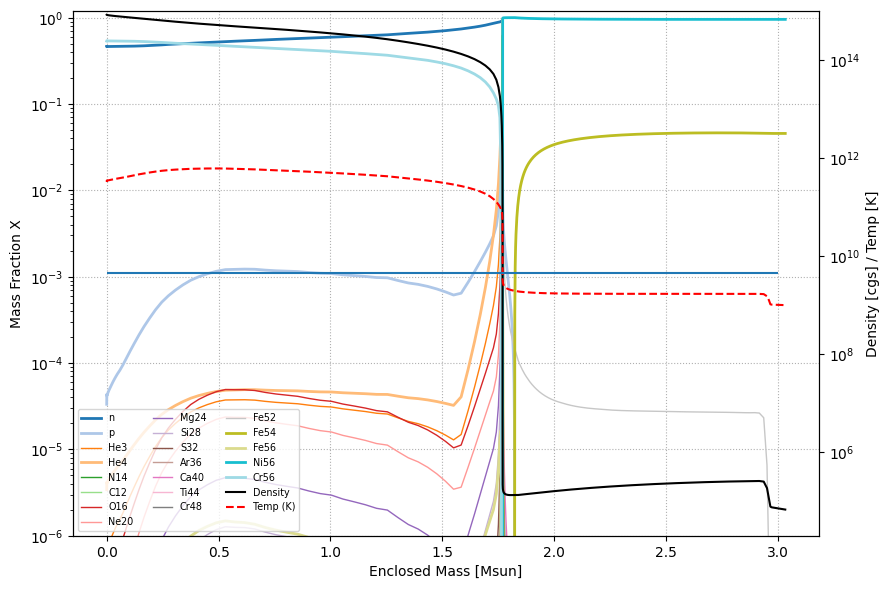

In [89]:
# Plot radial mass fractions with extended color palette and secondary y-axis for density & temperature
low_limit = 1e-6
n_species_plotted = sum(np.max(nse_X[:, j]) >= low_limit for j in range(len(nse_nuc_names)))
palette = sns.color_palette('tab20', n_species_plotted)
fig, ax = plt.subplots(figsize=(9,6))
idx = 0
handles = []
labels = []
for j, name in enumerate(nse_nuc_names):
    Xj = nse_X[:, j]
    if np.max(Xj) < low_limit: continue
    lw = 2 if np.max(Xj) > 0.05 else 1
    color = palette[idx]; idx += 1
    h = ax.plot(mass, Xj, linewidth=lw, color=color, label=name)[0]
    handles.append(h); labels.append(name)
ax.set_xlabel('Enclosed Mass [Msun]')
ax.set_ylabel('Mass Fraction X')
ax.set_yscale('log'); ax.set_ylim([low_limit, 1.2]); ax.grid(ls=':')
ax2 = ax.twinx()
dens_line = ax2.plot(mass, dens, color='black', linestyle='-', linewidth=1.5, label='Density')[0]
temp_line = ax2.plot(mass, temp, color='red', linestyle='--', linewidth=1.5, label='Temp (K)')[0]
ax2.set_yscale('log'); ax2.set_ylabel('Density [cgs] / Temp [K]')
handles.extend([dens_line, temp_line]); labels.extend(['Density','Temp (K)'])
ax.legend(handles, labels, ncol=3, fontsize='x-small', loc='lower left')
ax2.set_ylim(2e4,1e15)
ax2.hlines(4.5e9, 0, 3)
# ax2.set_xlim(1e4,2e9)
plt.tight_layout()

[]

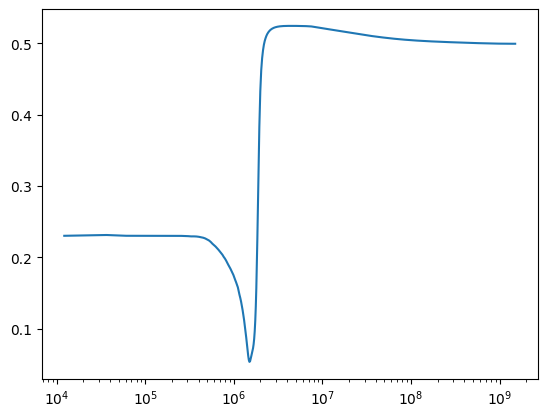

In [13]:
plt.plot(radius, ye)
plt.semilogx()